In [1]:
library(ggplot2)
library(igraph)
library(dplyr)
library(RColorBrewer)
library(progress)

library(foreach)
library(doParallel)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: iterators

Loading required package: parallel



## Functions and global parameters

In [2]:
edge_cmap <- colorRampPalette(c("darkblue", "white"))

In [3]:
## Some functions  ##

# Initialize the node features given the graph, F, q, and mode
initialize_features <- function(g, F, q, mode) {
  # Generate the features
  if (mode == "pois") {
    features <- lapply(1:vcount(g), function(x) rpois(F, q))
  } else if (mode == "unif") {
    features <- lapply(1:vcount(g), function(x) sample(1:q, F, replace = TRUE))
  }
  
  # Attach the feature to each node
  V(g)$features <- features

  return(g)
}


# Compute the cultural similarity (feature overlap) between two nodes
cultural_similarity <- function(g, i, j) {
  sum(V(g)[[i]]$features == V(g)[[j]]$features)
}


# Get the indices of the different features between two nodes
cultural_differences <- function(g, i, j) {
  which(V(g)[[i]]$features != V(g)[[j]]$features)
}


# Compute the cultural similarity between all pairs of nodes
edge_similarities <- function(g) {
  sapply(E(g), function(x) cultural_similarity(g, ends(g, x)[1], ends(g, x)[2]))
}


# Single step of the dynamical model
single_step <- function(g) {
  # Randomly select an edge
  random_edge <- sample(E(g), 1)

  # Get the nodes
  node_i <- ends(g, random_edge)[1]
  node_j <- ends(g, random_edge)[2]

  # Compute the cultural similarity
  cs <- cultural_similarity(g, node_i, node_j)

  # Compute the probability of interaction
  p <- cs / F

  # Interaction
  if (runif(1) < p && p < 1) {
    diff <- cultural_differences(g, node_i, node_j)
    feature_to_change <- sample(diff, 1)
    V(g)[[node_j]]$features[feature_to_change] <- V(g)[[node_i]]$features[feature_to_change]
  }

  return(g)
}


# Find the cultural domains
get_cultural_domains <- function(g) {
  # Get all unique feature sets
  unique_features <- unique(V(g)$features)

  sizes <- c()

  # Iterate over all unique feature sets
  for (f in unique_features) {
    # Get the nodes with the feature set
    nodes <- sapply(V(g)$features, function(x) identical(x, f))

    # Get the subgraph with the nodes
    subgraph <- induced_subgraph(g, nodes)

    # Find connected components in the subgraph and the LCC
    components <- components(subgraph)
  
    # Get the size of the LCC and update s_max
    sizes <- c(sizes, components$csize)
  }

  return(sizes)
}


# Find the largest cultural domain
get_s_max <- function(g) {
  sizes <- get_cultural_domains(g)
  return(max(sizes))
}


# Find the number of active bonds
get_n_active_bonds <- function(g, F) {
  es <- edge_similarities(g)
  active_bounds <- es[(es < F) & (es > 0)]
  return(length(active_bounds))
}

## Single shot dynamics

In [7]:
# Create the (lattice) graph
L <- 20
d <- 2
g <- make_lattice(length = L, dim = d)

In [8]:
# Hyperparameters
F <- 10 # Number of features
q <- 50 # Disorder parameter
mode <- "pois"

g <- initialize_features(g, F, q, mode)

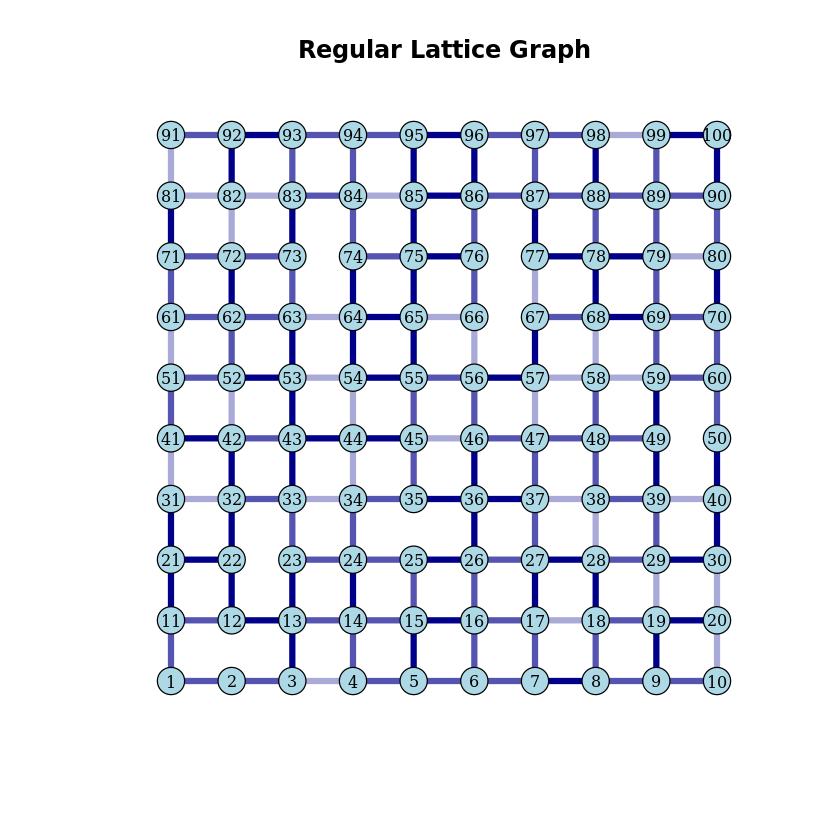

In [13]:
E(g)$similarity <- edge_similarities(g)

edge_colors <- edge_cmap(F)[cut(E(g)$similarity, breaks=F)]

plot(g, 
     layout=layout_on_grid(g),  # Use lattice layout for proper grid representation
     main="Regular Lattice Graph",  # Title of the plot
     vertex.size=10,  # Size of the vertices
     vertex.label.cex=0.8,  # Font size of vertex labels
     edge.color=edge_colors,  # Color of the edges
     edge.width=5,  # Size of the edges
     vertex.color="lightblue",  # Color of the vertices
     vertex.frame.color="black",  # Border color of the vertices
     vertex.label.color="black"  # Color of the vertex labels
)

In [15]:
## Dynamics ##

# Initialize the progress bar
total_steps <- 1e5
pb <- txtProgressBar(min = 1, max = total_steps, style = 3)

# Loop with progress bar
for (i in 1:total_steps) {
  g <- single_step(g)
  
  # Update the progress bar
  setTxtProgressBar(pb, i)
  

}

# Close the progress bar
close(pb)

  |                                                                      |   0%

Elapsed Time: 2.89292 mins, ETA: 0 mins39e-05 minss======================| 100%


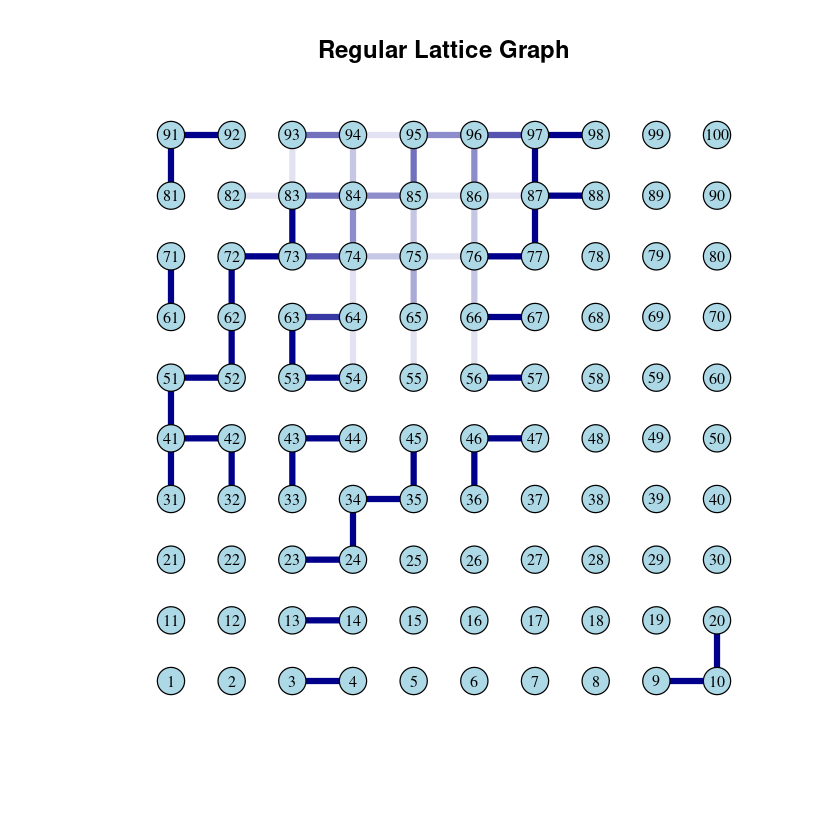

In [73]:
E(g)$similarity <- edge_similarities(g)

edge_colors <- edge_cmap(F)[cut(E(g)$similarity, breaks=F)]

plot(g, 
     layout=layout_on_grid(g),  # Use lattice layout for proper grid representation
     main="Regular Lattice Graph",  # Title of the plot
     vertex.size=10,  # Size of the vertices
     vertex.label.cex=0.8,  # Font size of vertex labels
     edge.color=edge_colors,  # Color of the edges
     edge.width=5,  # Size of the edges
     vertex.color="lightblue",  # Color of the vertices
     vertex.frame.color="black",  # Border color of the vertices
     vertex.label.color="black"  # Color of the vertex labels
)

In [56]:
get_nodes_cmap <- function(g){
  unique_features <- sample(unique(V(g)$features))
  nodes_cmap <- colorRampPalette(brewer.pal(12, "Set3"))(length(unique_features))
  feature_colors <- setNames(nodes_cmap, unique_features)
  vertex_colors <- feature_colors[as.character(V(g)$features)]
  return(vertex_colors)
}

In [55]:
sample(c(1, 3, 4))

[1] 4 1 3

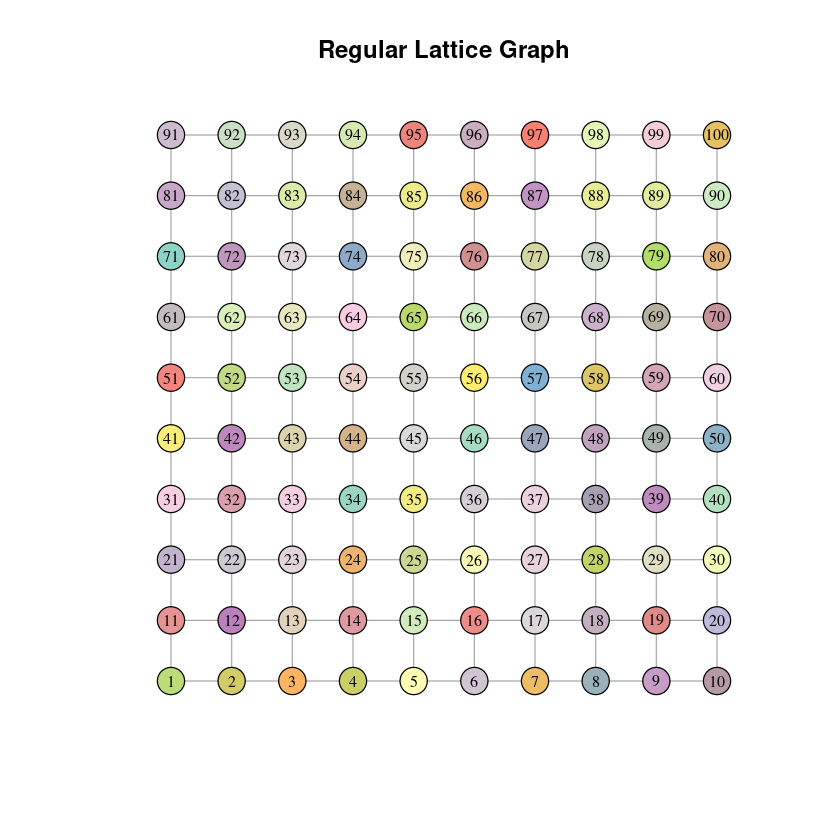

In [68]:
# Hyperparameters
F <- 10 # Number of features
q <- 10 # Disorder parameter
mode <- "pois"

g <- initialize_features(g, F, q, mode)

# Plot the graph
plot(g, 
     layout = layout_on_grid(g),  # Use lattice layout for proper grid representation
     main = "Regular Lattice Graph",  # Title of the plot
     vertex.size = 10,  # Size of the vertices
     vertex.label.cex = 0.8,  # Font size of vertex labels
     vertex.color = get_nodes_cmap(g),  # Color of the vertices
     vertex.frame.color = "black",  # Border color of the vertices
     vertex.label.color = "black"  # Color of the vertex labels
)

In [69]:
## Dynamics ##
pb <- txtProgressBar(min = 0, max = 100000, style = 3)
for(i in 1:100000) {
  g <- single_step(g)
  setTxtProgressBar(pb, i)
}
close(pb)

  |                                                                      |   0%

  |======================================================================| 100%


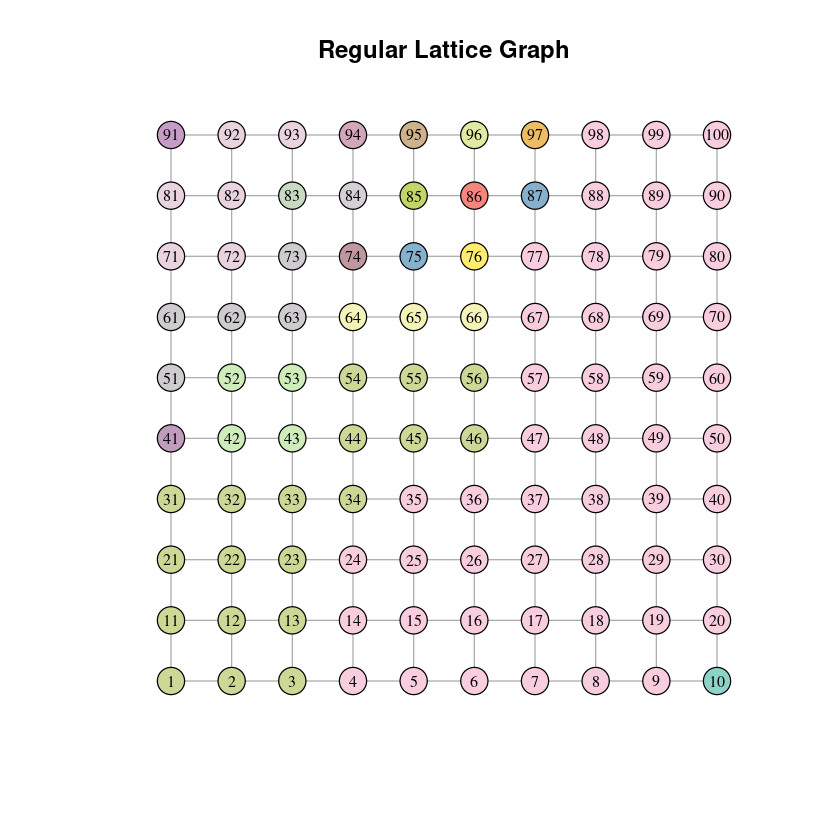

In [70]:
# Plot the graph
plot(g,
     layout = layout_on_grid(g),  # Use lattice layout for proper grid representation
     main = "Regular Lattice Graph",  # Title of the plot
     vertex.size = 10,  # Size of the vertices
     vertex.label.cex = 0.8,  # Font size of vertex labels
     vertex.color = get_nodes_cmap(g),  # Color of the vertices
     vertex.frame.color = "black",  # Border color of the vertices
     vertex.label.color = "black"  # Color of the vertex labels
)

## Analysis

In [4]:
# # Iterations, fixed L, F, varying q
# L_list <- c(50)
# F_list <- c(2, 3, 6, 10)
# q_list <- c(1, 10, 100, 200, 250, 300, 400, 500, 1000)
# rep_mc <- 5
# max_iterations <- 1e6
# mode <- "pois"

# L_list <- c(5, 10)
# F_list <- c(4, 7)
# q_list <- c(1, 10)
# rep_mc <- 2
# max_iterations <- 1e5

# log_scale <- unique(round(10^(seq(log(1), log(max_iterations), length.out = 48))))

# res <- data.frame()


# # Define the progress bar
# i_pb <- 0
# max_pb <- length(L_list) * length(F_list) * length(q_list) * rep_mc
# pb <- txtProgressBar(min = 0, max = max_pb, style = 3)

# # Loop over the different values of L
# for (L in L_list){

#   # Loop over the different values of L
#   for (F in F_list){

#     # Loop over the different values of q
#     for (q in q_list){

#       # Repeat the simulation 10 times
#       for (mc in 1:rep_mc){

#         # Create and initialize the graph
#         g <- make_lattice(length = L, dim = 2)
#         n_edges <- ecount(g)
#         N <- vcount(g)
#         g <- initialize_features(g, F, q, mode)

#         # Iterate the dynamics
#         for (j in 1:max_iterations){
#           g <- single_step(g)

#           # Save the results
#           if (j %in% log_scale) {
#             s_max <- get_s_max(g)
#             n_active_bonds <- get_n_active_bonds(g, F)
#             n_den <- n_active_bonds / n_edges

#             res <- rbind(res,
#               data.frame(mc = mc,
#                          L = L,
#                          F = F,
#                          q = q,
#                          s_max_den = s_max / N,
#                          n_density = n_den,
#                          iteration = j))
#             cat(j)
#           }
#         } # End of iterations

#         i_pb <- i_pb + 1
#         setTxtProgressBar(pb, i_pb)

#       } # End of rep_mc
#     } # End of q_list
#   } # End of F_list
# } # End of L_list

# close(pb)

In [28]:
# Parallel computation
num_cores <- detectCores() # Get the number of cores
cl <- makeCluster(num_cores) # Create a cluster with the number of cores
registerDoParallel(cl) # Register the parallel backend

sprintf("Number of cores: %d", num_cores)

[1] "Number of cores: 8"

In [6]:
# # Iterations, fixed L, F, varying q
# L_list <- c(50)
# F_list <- c(2, 3, 6, 10)
# q_list <- c(1, 10, 100, 200, 250, 300, 400, 500, 1000)
# rep_mc <- 5
# max_iterations <- 1e6
# mode <- "pois"

# L_list <- c(20)
# F_list <- c(10)
# q_list <- c(500)
# rep_mc <- 1
# max_iterations <- 1e7

# log_scale <- unique(round(10^(seq(log(1), log(max_iterations), length.out = 48))))
# log_scale <- c(log_scale, max_iterations)


# # Start timing the computation
# start_time <- Sys.time()

# # Loop over the different values of L and F
# res <- foreach(L = L_list, .combine = rbind) %:%
#   foreach(F = F_list, .combine = rbind) %:%
#   foreach(q = q_list, .combine = rbind, .packages = c('igraph')) %dopar% {
#     # Initialize a local result variable
#     local_res <- data.frame()

#     # Repeat the simulation 10 times
#     for (mc in 1:rep_mc) {
#       # Create and initialize the graph
#       g <- make_lattice(length = L, dim = 2)
#       n_edges <- ecount(g)
#       N <- vcount(g)
#       g <- initialize_features(g, F, q, mode)

#       # Iterate the dynamics
#       for (j in 1:max_iterations) {
#         g <- single_step(g)

#         # Save the results
#         if (j %in% log_scale) {
#           s_max <- get_s_max(g)
#           n_active_bonds <- get_n_active_bonds(g, F)
#           n_den <- n_active_bonds / n_edges

#           local_res <- rbind(local_res,
#             data.frame(mc = mc,
#                        L = L,
#                        F = F,
#                        q = q,
#                        s_max_den = s_max / N,
#                        n_density = n_den,
#                        iteration = j))
#         }
#       } # End of iterations

#       # Update iteration counter and log progress
#     } # End of rep_mc
    
#     return(local_res)
#   } # End of nested foreach loops

# # Stop the cluster
# stopCluster(cl)

# # End timing the computation
# end_time <- Sys.time()
# elapsed_time <- end_time - start_time
# cat(sprintf("Total computation time: %s\n", elapsed_time))

In [29]:
## Change method to parallelize

# Iterations, fixed L, F, varying q
L_list <- c(50)
F_list <- c(2, 3, 6, 10)
q_list <- c(1, 10, 100, 200, 250, 300, 400, 500, 1000)
rep_mc <- 5
max_iterations <- 1e6
mode <- "pois"

L_list <- c(20)
F_list <- c(10)
q_list <- c(1, 10, 100, 200, 250, 300, 400, 500)
rep_mc <- 3
max_iterations <- 1e2

log_scale <- unique(round(10^(seq(log(1), log(max_iterations), length.out = 48))))
log_scale <- c(log_scale, max_iterations)

# Create a data frame with all combinations
combinations <- expand.grid(L = L_list, F = F_list, q = q_list)

start_time <- Sys.time()
for (mc in 1:rep_mc){
  # Start timing the computation

  # Parallel execution using foreach
  res <- foreach(i = 1:nrow(combinations), .combine = rbind, .packages = 'igraph') %dopar% {
    # Extract the combination
    L <- combinations$L[i]
    F <- combinations$F[i]
    q <- combinations$q[i]

    # Initialize a local result variable
    local_res <- data.frame()

    # Create and initialize the graph
    g <- make_lattice(length = L, dim = 2)
    n_edges <- ecount(g)
    N <- vcount(g)
    g <- initialize_features(g, F, q, mode)

    # Iterate the dynamics
    for (j in 1:max_iterations) {
      g <- single_step(g)

      # Save the results
      if (j %in% log_scale) {
        s_max <- get_s_max(g)
        n_active_bonds <- get_n_active_bonds(g, F)
        n_den <- n_active_bonds / n_edges

        local_res <- rbind(local_res,
          data.frame(mc = mc,
                      L = L,
                      F = F,
                      q = q,
                      s_max_den = s_max / N,
                      n_density = n_den,
                      iteration = j))
      }
    } # End of iterations
    
    log_file <- paste0("worker_log_", Sys.getpid(), ".txt")
    write(paste("Processing L:", L, "F:", F, "q:", q, "mc:", mc), file = log_file, append = TRUE)

    return(local_res)
  } # End of nested foreach loops

  write.csv(res, paste0("res_", mc, ".csv"), row.names = FALSE)

} # End of rep_mc

# Stop the cluster
stopCluster(cl)

# End timing the computation
end_time <- Sys.time()
elapsed_time <- end_time - start_time
cat(sprintf("Total computation time: %s\n", elapsed_time))

Total computation time: 13.3641777038574


In [30]:
combinations

L,F,q
<dbl>,<dbl>,<dbl>
20,10,1
20,10,10
20,10,100
20,10,200
20,10,250
20,10,300
20,10,400
20,10,500


In [16]:
# Save res in csv
# write.csv(res, "res.csv", row.names = FALSE)

In [43]:
# Load res from csv
res <- read.csv("resultspy2.csv")

In [44]:
sprintf("Unique q values: %s", paste(unique(res$q), collapse = ", "))
sprintf("Unique F values: %s", paste(unique(res$F), collapse = ", "))
sprintf("Unique L values: %s", paste(unique(res$L), collapse = ", "))

[1] "Unique q values: 1, 10, 100, 200, 300, 500"

[1] "Unique F values: 2, 5, 10"

[1] "Unique L values: 50"

In [45]:
# Filter the results and summarize the Monte Carlo simulations
df <- res |>
  filter (L == 50, F == 10) |>
  group_by(q, iteration) |>
  summarize(
    s_avg=mean(s_max_den), s_sd=sd(s_max_den), 
    n_avg=mean(n_density), n_sd=sd(n_density),
    .groups = 'drop'
  )

tail(df)

q,iteration,s_avg,s_sd,n_avg,n_sd
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
500,2335721469,0.004800000,0.0000000000,0.01462585,0.004364358
500,2976351441,0.003600000,0.0004000000,0.01367347,0.001241380
500,3792690190,0.004133333,0.0006110101,0.01510204,0.003587428
500,4832930238,0.004666667,0.0002309401,0.01462585,0.002143667
500,6158482110,0.005466667,0.0011547005,0.01428571,0.002040816
500,7847599703,0.004533333,0.0002309401,0.01442177,0.002755732


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 36 rows containing non-finite outside the scale range
(`stat_smooth()`).”


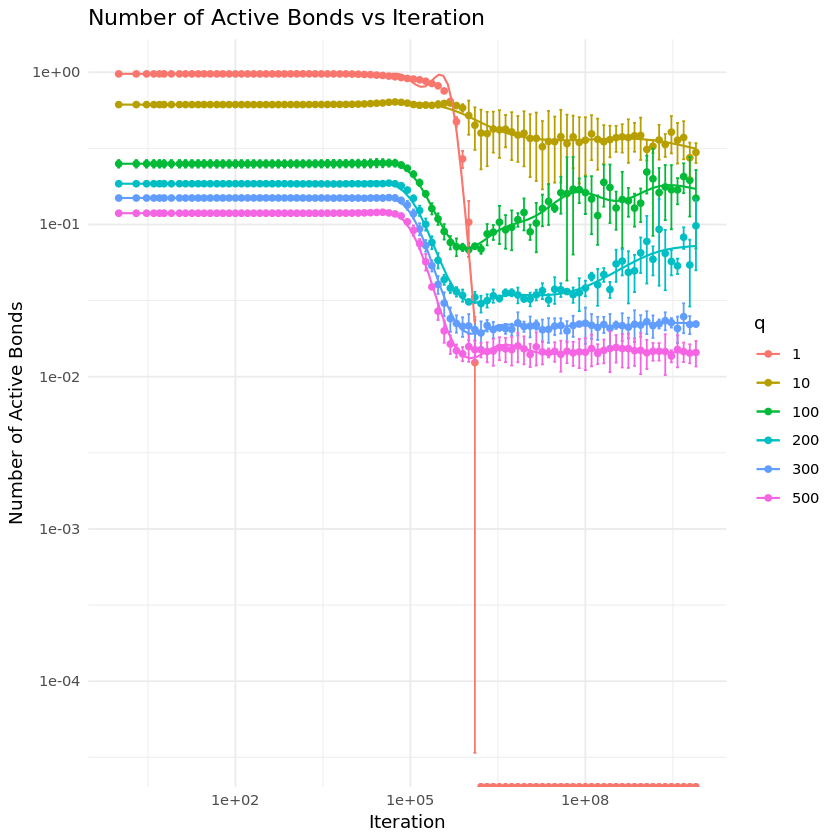

In [46]:
# Plot number of active bonds vs iteration per each q
ggplot(df, aes(x = iteration, y = n_avg, color = factor(q))) +
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin = n_avg - n_sd, ymax = n_avg + n_sd), width = 0.05) +  # Error bars
  geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=15), se = FALSE, linewidth = 0.6) + # Smooth line
  scale_x_log10() +  # Log scale for x-axis
  scale_y_log10() +  # Log scale for y-axis
  labs(
    title = "Number of Active Bonds vs Iteration",
    x = "Iteration",
    y = "Number of Active Bonds",
    color = "q"
  ) +
  theme_minimal()

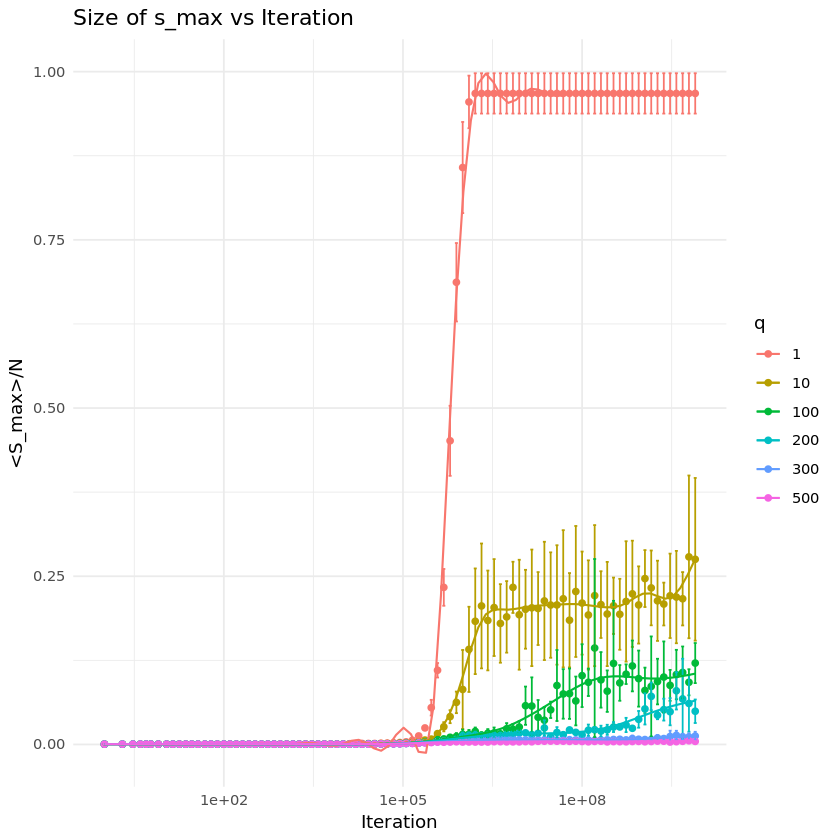

In [47]:
# Plot number of s_max vs iteration per each q
ggplot(df, aes(x = iteration, y = s_avg, color = factor(q))) +
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin=(s_avg-s_sd), ymax=(s_avg+s_sd), width = 0.05)) +  # Error bars
  geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=25), se = FALSE, linewidth = 0.6) +
  scale_x_log10() +  # Log scale for x-axis
  labs(
    title = "Size of s_max vs Iteration",
    x = "Iteration",
    y = "<S_max>/N",
    color = "q"
  ) +
  theme_minimal()

In [48]:

df <- res |>
  filter(iteration == max(iteration), L == 50) |>
  group_by(q, F) |>
  summarize(
    s_avg=mean(s_max_den), s_sd=sd(s_max_den), 
    n_avg=mean(n_density), n_sd=sd(n_density),
    .groups = 'drop'
  )  
  
df

q,F,s_avg,s_sd,n_avg,n_sd
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,0.088266667,0.0136137186,0.1290476190,0.0248815045
1,5,0.501333333,0.1476028907,0.1304761905,0.0811234972
1,10,0.967600000,0.0299946662,0.0000000000,0.0000000000
10,2,0.006133333,0.0008326664,0.0228571429,0.0008163265
10,5,0.068400000,0.0501182601,0.3764625850,0.0525391638
10,10,0.275200000,0.1209052522,0.2976870748,0.0443201847
100,2,0.002000000,0.0000000000,0.0036054422,0.0007167111
100,5,0.004133333,0.0016165808,0.0173469388,0.0035406840
100,10,0.120933333,0.0297787396,0.1488435374,0.0793308997


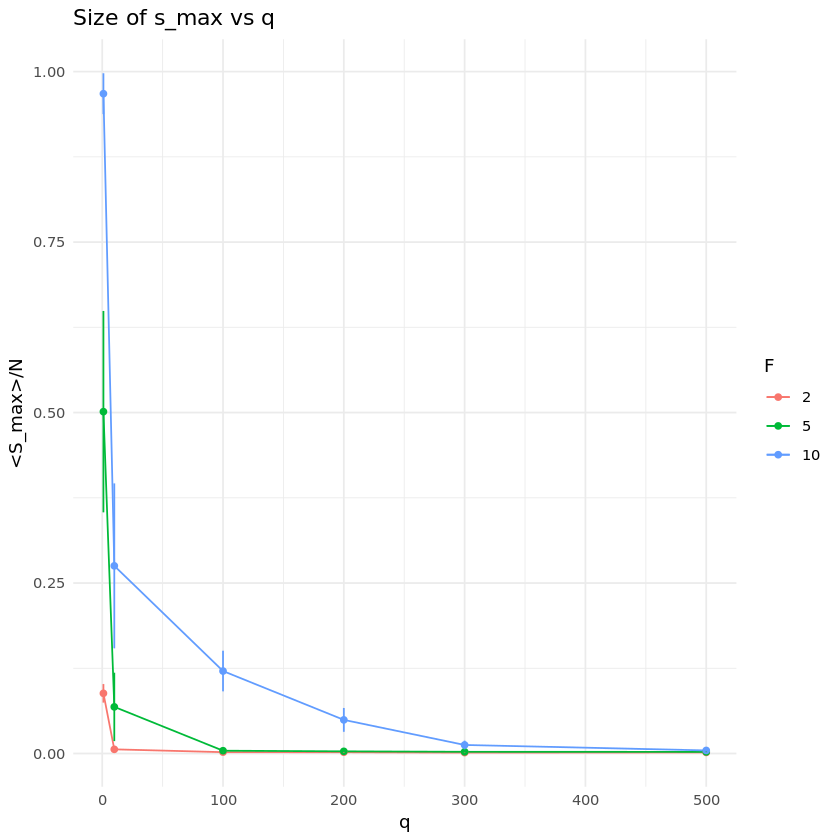

In [49]:
# Plot number of s_max vs q per each L
ggplot(df, aes(x = q, y = s_avg, color = factor(F))) +
  geom_line() +  # Line plot for the mean values
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin=(s_avg-s_sd), ymax=(s_avg+s_sd), width = 0.05)) +  # Error bars
  #geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=1), se = FALSE, linewidth = 0.6) +
  # scale_x_log10() +  # Log scale for x-axis
  labs(
    title = "Size of s_max vs q",
    x = "q",
    y = "<S_max>/N",
    color = "F"
  ) +
  theme_minimal()

In [61]:
res <- read.csv("./temp_data/ER_0-007.csv")
sprintf("Unique q values: %s", paste(unique(res$q), collapse = ", "))
sprintf("Unique F values: %s", paste(unique(res$F), collapse = ", "))

[1] "Unique q values: 1, 10, 100, 200"

[1] "Unique F values: 2, 10"

In [62]:
# Filter the results and summarize the Monte Carlo simulations
df <- res |>
  filter (F == 2) |>
  group_by(q, iteration) |>
  summarize(
    s_avg=mean(s_max_den), s_sd=sd(s_max_den), 
    n_avg=mean(n_density), n_sd=sd(n_density),
    .groups = 'drop'
  )

tail(df)

q,iteration,s_avg,s_sd,n_avg,n_sd
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
200,19668038,0.005333333,0.001154701,0.005023221,0.001935416
200,23702974,0.005000000,0.001000000,0.004738887,0.001737305
200,28565684,0.005000000,0.001000000,0.004644110,0.001565985
200,34425988,0.005000000,0.001000000,0.005117998,0.002050356
200,41488545,0.005000000,0.001000000,0.004928443,0.001997091
200,49999999,0.004666667,0.001154701,0.004738887,0.001737305


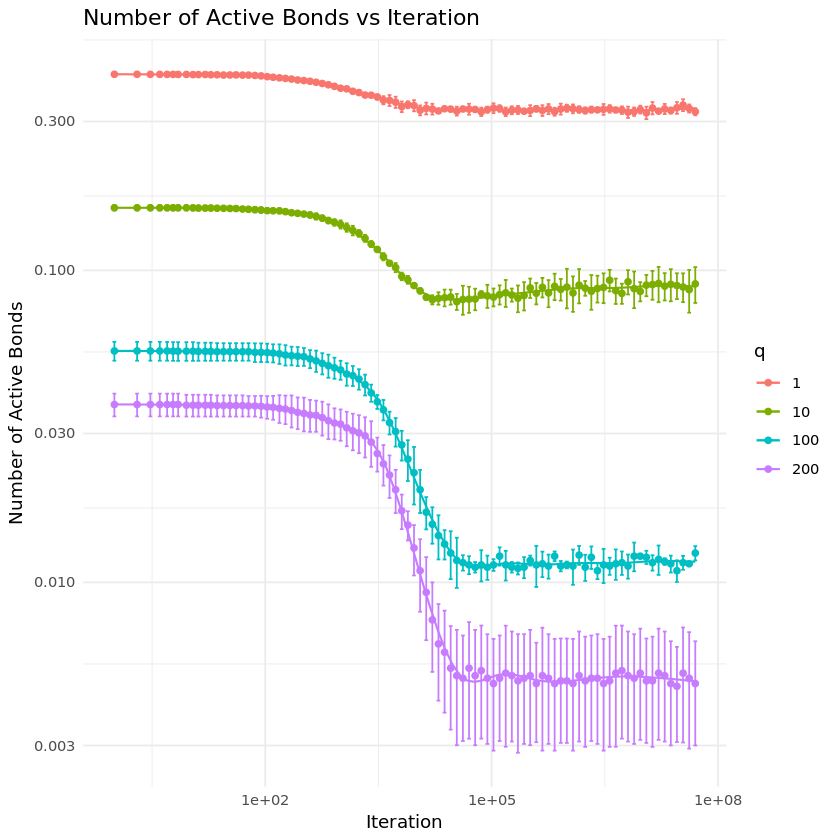

In [63]:
# Plot number of active bonds vs iteration per each q
ggplot(df, aes(x = iteration, y = n_avg, color = factor(q))) +
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin = n_avg - n_sd, ymax = n_avg + n_sd), width = 0.05) +  # Error bars
  geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=15), se = FALSE, linewidth = 0.6) + # Smooth line
  scale_x_log10() +  # Log scale for x-axis
  scale_y_log10() +  # Log scale for y-axis
  labs(
    title = "Number of Active Bonds vs Iteration",
    x = "Iteration",
    y = "Number of Active Bonds",
    color = "q"
  ) +
  theme_minimal()

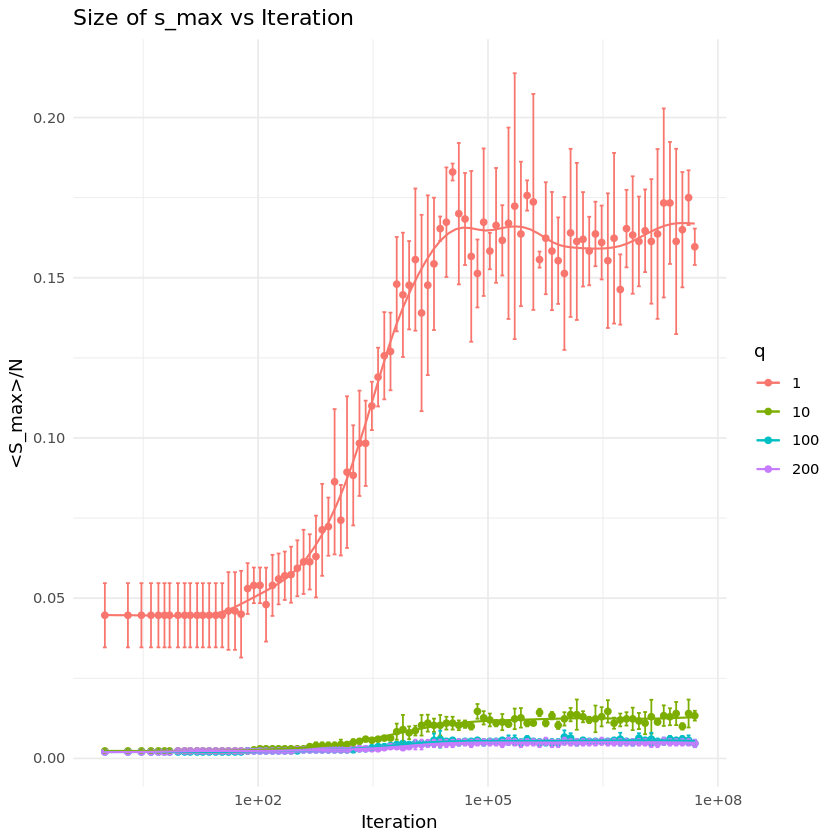

In [64]:
# Plot number of s_max vs iteration per each q
ggplot(df, aes(x = iteration, y = s_avg, color = factor(q))) +
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin=(s_avg-s_sd), ymax=(s_avg+s_sd), width = 0.05)) +  # Error bars
  geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=25), se = FALSE, linewidth = 0.6) +
  scale_x_log10() +  # Log scale for x-axis
  labs(
    title = "Size of s_max vs Iteration",
    x = "Iteration",
    y = "<S_max>/N",
    color = "q"
  ) +
  theme_minimal()

In [65]:

df <- res |>
  filter(iteration == max(iteration)) |>
  group_by(q, F) |>
  summarize(
    s_avg=mean(s_max_den), s_sd=sd(s_max_den), 
    n_avg=mean(n_density), n_sd=sd(n_density),
    .groups = 'drop'
  )  
  
df

q,F,s_avg,s_sd,n_avg,n_sd
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,0.159666667,0.005686241,0.322528670,0.0084554287
1,10,0.020666667,0.002081666,0.899914700,0.0037289955
10,2,0.013333333,0.001527525,0.090512748,0.0119092302
10,10,0.026333333,0.004725816,0.561747702,0.0033682790
100,2,0.004666667,0.001154701,0.012415885,0.0006566395
100,10,0.020666667,0.006429101,0.185669605,0.0105280117
200,2,0.004666667,0.001154701,0.004738887,0.0017373048
200,10,0.014666667,0.001154701,0.125390958,0.0079613307


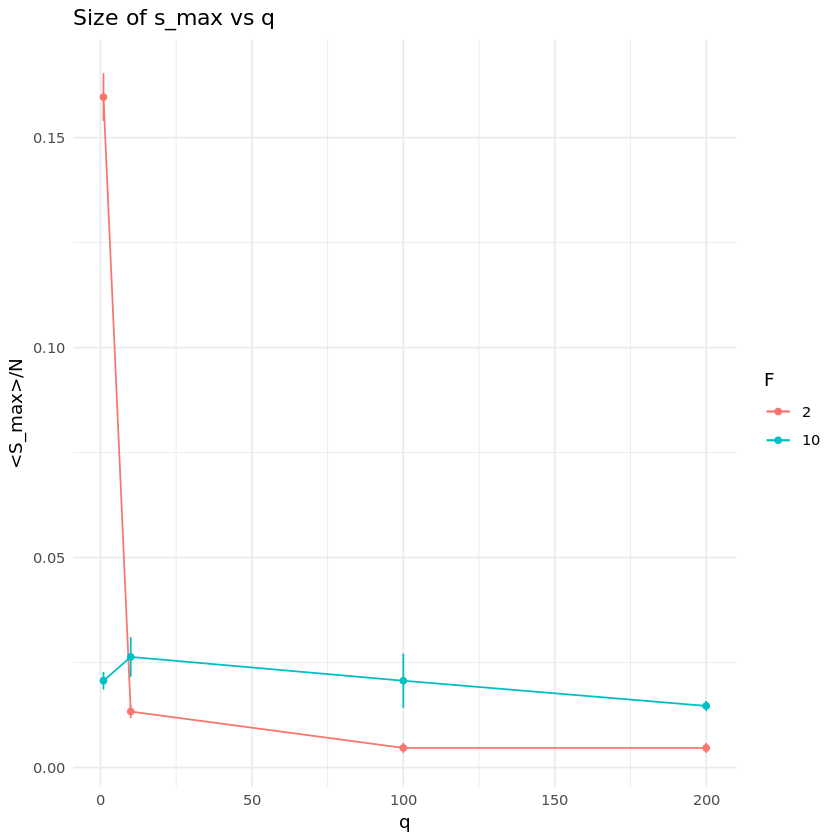

In [66]:
# Plot number of s_max vs q per each L
ggplot(df, aes(x = q, y = s_avg, color = factor(F))) +
  geom_line() +  # Line plot for the mean values
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin=(s_avg-s_sd), ymax=(s_avg+s_sd), width = 0.05)) +  # Error bars
  #geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=1), se = FALSE, linewidth = 0.6) +
  # scale_x_log10() +  # Log scale for x-axis
  labs(
    title = "Size of s_max vs q",
    x = "q",
    y = "<S_max>/N",
    color = "F"
  ) +
  theme_minimal()